## 0. Logistics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install mord
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
import os
import spacy
import numpy as np
import pandas as pd

from mord import LogisticAT
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, \
                            mean_absolute_error as MAE
from sklearn.model_selection import cross_val_score, \
                                    StratifiedShuffleSplit as SSSplit

import tensorflow as tf
from tensorflow.python.keras import preprocessing as prep
from tensorflow.python.keras import models, initializers
from tensorflow.python.keras import layers as L                                    

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spacy_nlp = spacy.load('en_core_web_lg')

In [4]:
home_path = '/content/drive/My Drive/Colab Notebooks/assgn'
data_path = os.path.join(home_path, 'original.csv')

# Texts to Decades

Task: predict the reviewer’s birth decade (90’s, 80’s, 00’s, etc)  using only text features.

## 1. Data exploration
The dataset was web-scraped around 2016 ([dataset author's post](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/discussion/65898)). `Atext` concats `Title` and `Review Text`.

In [5]:
df = pd.read_csv(data_path, index_col=0)
df.fillna('', inplace=True)
df['Atext'] = df['Title'] + ' ' + df['Review Text']
## age should be in (6, 106]; shift decades from [1, 9] to [0, 8]
df['Dec'] = (2016 - df['Age'] - 1900) // 10 - 1  

#### other prediction targets to explore:
#### 3-age-group, 4-age-group, department-name

# df['Age3g'] = df['Age'] // 10 // 3
# df['Age4g'] = df['Age'] // 10 // 2.5
# dlabels = list(set(df['Department Name']))
# dlabels = {d: i for i, d in enumerate(dlabels)}
# df['DepCode'] = [dlabels[n] for n in df['Department Name']]

####

df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Atext,Dec
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,7
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,7
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,4
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...",5
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,5


Reviewers' age distribution.

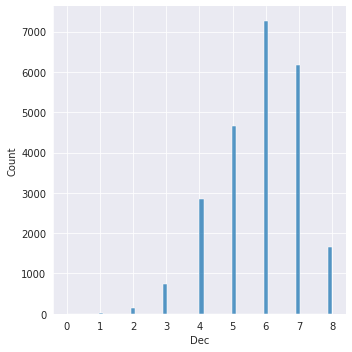

In [6]:
sns.set_style('darkgrid'); sns.displot(df['Dec'])

Description of lengths of normalized texts.

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOP_SET = set(stopwords.words('english'))    
REPLACE_BY_SPACE = re.compile(r'[/(){}\[\]\|@.,;]')
GOOD_SYMBOLS = re.compile(r'[^0-9a-z !?]')
PUNCT_SPACE = re.compile(r'([!?])')
EXTRA_SPACE = re.compile(r'\s+')

def text_prepare(s):
    s = s.lower()
    s = REPLACE_BY_SPACE.sub(' ', s)
    s = GOOD_SYMBOLS.sub('', s)
    s = ' '.join([w for w in s.split() 
                    if w and w not in STOP_SET])
    s = PUNCT_SPACE.sub(r' \1 ', s)
    s = EXTRA_SPACE.sub(' ', s)
    return s.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['Prep'] = [text_prepare(s) for s in df['Atext']]
df['Len'] = [len(s.split()) for s in df['Prep']]

Text lengths (max, mean, std) and S/W ratio

In [9]:
print('Prepared text lengths:\n\tmax = %d\n\tmean = %.2f\n\tstd = %.2f' %
      (df['Len'].max(), df['Len'].mean(), df['Len'].std()))
print('\n(# of samples / # of words per sample): %.2f' % 
      (len(df) / df['Len'].mean()))

Prepared text lengths:
	max = 77
	mean = 31.62
	std = 15.34

(# of samples / # of words per sample): 742.77


The age group doesn't seem to correlate with the text length

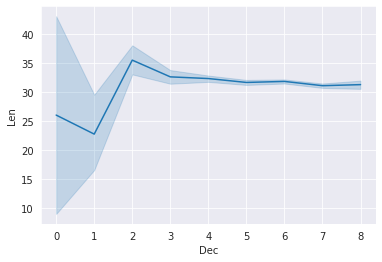

In [10]:
sns.lineplot(data=df, x='Dec', y='Len')

## 2. Data splits
Train 70% - Val 15% - Test 15% (16k, 3.5k, 3.5k)

In [11]:
## get the test set indices and the rest
source_col = 'Prep'
target_col = 'Dec'
random_state = 1
idx_, idx_test = next(SSSplit(n_splits=1, 
                      test_size=0.15, 
                      random_state=random_state).split(df[source_col], 
                                                       df[target_col]))
X_test, y_test = df[source_col][idx_test], df[target_col][idx_test]

## get the (train + val) sets
X_train_val, y_train_val = df[source_col][idx_], df[target_col][idx_]
num_classes = len(set(y_train_val))
print('Class label set:', set(y_train_val))

idx_train, idx_val = next(
    SSSplit(n_splits=1, 
            test_size=15 / 85, 
            random_state=random_state).split(X_train_val, 
                                             y_train_val))
X_train, y_train = df[source_col][idx_train], df[target_col][idx_train]
X_val, y_val = df[source_col][idx_val], df[target_col][idx_val]

Class label set: {0, 1, 2, 3, 4, 5, 6, 7, 8}


In [12]:
for i in range(5):
    print('"%s..."' % X_train.iloc[i][:50], y_train.iloc[i])

"great classic boyfriend jean distressed bought sto..." 7
"unique love unique tshirt fall colors ranchers the..." 5
"best shirt ever bought colors wish could buy color..." 7
"dont miss top great top worth money nice flow soft..." 5
"cute romper material meh cute romper love pattern ..." 7


## 3. Baseline
Since S/W ratio is less than 1500 (see [this recommendation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5?hl=en)), it makes sense to try n-gram bag-of-words models. These baseline models give a sense about at least how much better we can do than guessing randomly or by the mode (70s).

In [13]:
def guessMode(input, mode=6):
    return np.array([mode] * input.shape[0])

def guessRandom(input, lo=0, hi=8):
    return np.random.randint(lo, hi + 1, input.shape[0])

def model_assess(title, y_true, y_pred):
    print('%s:\n' % title,
        'MAE: %.3f' % MAE(y_true, y_pred),
        'Acc: %.3f' % accuracy_score(y_true, y_pred),
        'F1: %.3f' % f1_score(y_true, y_pred, average='micro'), 
        end='\n\n')

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, 
                                   ngram_range=(1, 2),
                                   token_pattern='(\S+)')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf =  tfidf_vectorizer.transform(X_val)
X_test_tfidf =  tfidf_vectorizer.transform(X_test)
print('TFIDF vocab size', len(tfidf_vectorizer.vocabulary_))

TFIDF vocab size 19696


It is reported [here](https://rikunert.com/ordinal_rating) that ordinal classification (e.g. ratings) are better served by *ordered logistic regression* (LAT) than by *logistic regressions* (LR).  
* features of 90s are closer to features of 80s than those of 50s;
* predicting 90s for 80s is better than predicting 50s.

Both LAT & LR are experiemnted.


In [15]:
clf_LR = LogisticRegression(C=1, max_iter=1000)
clf_LAT = LogisticAT(alpha=0.01, verbose=1, max_iter=10000)
clf_LR.fit(X_train_tfidf, y_train)
clf_LAT.fit(X_train_tfidf, y_train)

LogisticAT(alpha=0.01, max_iter=10000, verbose=1)

n-grams models fare slightly better than guessing, but underfit even when minimizing regularization coef. 
For this particular task, it seems that ignoring the ordinal nature of the labels doesn't hurt much. **Thus the following deep models go with multiclass classification**

In [16]:
model_assess('OrdLogiAT - train', 
             y_train, clf_LAT.predict(X_train_tfidf))
model_assess('OrdLogiAT - val', 
             y_val, clf_LAT.predict(X_val_tfidf))
model_assess('LogiReg - train', 
             y_train, clf_LR.predict(X_train_tfidf))
model_assess('LogiReg - val', 
             y_val, clf_LR.predict(X_val_tfidf))
model_assess('Guess mode - val', 
             y_val, guessMode(X_val_tfidf))
model_assess('Guess random - val', 
             y_val, guessRandom(X_val_tfidf))

OrdLogiAT - train:
 MAE: 0.111 Acc: 0.895 F1: 0.895

OrdLogiAT - val:
 MAE: 1.331 Acc: 0.236 F1: 0.236

LogiReg - train:
 MAE: 0.577 Acc: 0.660 F1: 0.660

LogiReg - val:
 MAE: 0.991 Acc: 0.343 F1: 0.343

Guess mode - val:
 MAE: 0.984 Acc: 0.306 F1: 0.306

Guess random - val:
 MAE: 2.764 Acc: 0.104 F1: 0.104



## 4. Deep models
Since the baseline capacity is insufficient, we experiment with deep models:
*   Basic CNN (with frozen GloVe embedding)
*   Separable CNN
*   Transformer

These are parallizable & computationally efficient.  
The next step can be character-level CNN, large-scale pretrained encoder (BERT), recurrent networks ...


In [17]:
#### build vocabulary & tokenzier
MAX_LEN = 60                # roughly (mean + 2 * std)
MAX_VOCAB_SIZE = 2 ** 14    # comparable to TFIDF vocab size

tokenizer = prep.text.Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    filters='"#$%&()*+.,-/:;<=>@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)

X_train_vec = tokenizer.texts_to_sequences(X_train)
max_len = len(max(X_train_vec, key=len))
max_len = min(MAX_LEN, max_len)
X_train_vec = prep.sequence.pad_sequences(X_train_vec, maxlen=max_len)

X_val_vec = tokenizer.texts_to_sequences(X_val)
X_val_vec = prep.sequence.pad_sequences(X_val_vec, maxlen=max_len)

X_test_vec = tokenizer.texts_to_sequences(X_test)
X_test_vec = prep.sequence.pad_sequences(X_test_vec, maxlen=max_len)

In [18]:
def get_opt():
    return tf.keras.optimizers.Adam(learning_rate=1e-3)

callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3)]

### 4.1 Basic CNN
As described in [here](https://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf) and [here](https://arxiv.org/pdf/1408.5882.pdf) (with frozen GloVe embedding).  
GloVe + "basic" models won't benifit much from tuable embedding (Sam Bowman p.c.). Experimented and confirmed (results omitted).

In [19]:
SPACY_EMB_SIZE = 300
emb_matrix = np.zeros((vocab_size, SPACY_EMB_SIZE))
for w, i in tokenizer.word_index.items():
    emb_matrix[i] = spacy_nlp(w).vector

In [28]:
def build_cnn_model(embedding_dim,
                    num_classes,
                    num_features,
                    input_shape,
                    filters=100,
                    hidden_dim=256,
                    dropout_rate=0.2):
    t_in = L.Input(shape=input_shape, dtype='int64')
    embedding = L.Embedding(
        input_dim=num_features,
        output_dim=embedding_dim,
        embeddings_initializer=initializers.Constant(emb_matrix),
        trainable=False)(t_in)
    
    tri_gram = L.Conv1D(filters, 3, padding='same', 
                        activation='relu')(embedding)
    tri_gram = L.GlobalMaxPooling1D()(tri_gram)
    
    quart_gram = L.Conv1D(filters, 4, padding='same', 
                          activation='relu')(embedding)
    quart_gram = L.GlobalMaxPooling1D()(quart_gram)
    
    quint_gram = L.Conv1D(filters, 5, padding='same', 
                          activation='relu')(embedding)
    quint_gram = L.GlobalMaxPooling1D()(quint_gram)

    concat = L.Concatenate(axis=1)([tri_gram, quart_gram, quint_gram])
    t_den = L.Dense(hidden_dim, activation='relu')(concat)
    t_den = L.Dropout(dropout_rate)(t_den)
    t_out = L.Dense(num_classes, activation='softmax')(t_den)
    model = models.Model(t_in, t_out)
    return model

model_cnn = build_cnn_model(
    embedding_dim=SPACY_EMB_SIZE,
    num_classes=num_classes,
    num_features=vocab_size,
    input_shape=[max_len],
    dropout_rate=0.5)

model_cnn.compile(optimizer=get_opt(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

In [29]:
model_cnn.fit(
    X_train_vec,
    y_train,                     
    epochs=40,
    callbacks=callbacks,
    validation_data=(X_val_vec, y_val), 
    verbose=1, # progress bar  
    batch_size=128)
print('Trainning stopped.')
model_cnn.save(os.path.join(home_path, 'text2dec_cnn_model.h5'))

Epoch 1/40
129/129 [==============================] - 2s 14ms/step - loss: 1.7099 - acc: 0.2891 - val_loss: 1.6359 - val_acc: 0.3063
Epoch 2/40
129/129 [==============================] - 1s 11ms/step - loss: 1.6078 - acc: 0.3200 - val_loss: 1.6114 - val_acc: 0.3185
Epoch 3/40
129/129 [==============================] - 1s 11ms/step - loss: 1.5486 - acc: 0.3462 - val_loss: 1.5977 - val_acc: 0.3222
Epoch 4/40
129/129 [==============================] - 1s 11ms/step - loss: 1.4538 - acc: 0.3936 - val_loss: 1.6023 - val_acc: 0.3216
Epoch 5/40
129/129 [==============================] - 1s 11ms/step - loss: 1.3229 - acc: 0.4648 - val_loss: 1.6348 - val_acc: 0.3196
Epoch 6/40
129/129 [==============================] - 1s 10ms/step - loss: 1.1106 - acc: 0.5566 - val_loss: 1.7613 - val_acc: 0.3120
Trainning stopped.


### 4.2 sepCNN 
[Depthwise Separable Convolutional Network](https://arxiv.org/abs/1610.02357), recommended [here](https://developers.google.com/machine-learning/guides/text-classification/step-4), where an implementation is given.

In [30]:
def build_sepcnn_model(filters,
                       kernel_size,
                       embedding_dim,
                       dropout_rate,
                       pool_size,
                       input_shape,
                       num_classes,
                       num_features):
    
    model = models.Sequential()
    model.add(L.Embedding(input_dim=num_features,
                          output_dim=embedding_dim,
                          input_length=input_shape[0]))

    model.add(L.Dropout(rate=dropout_rate))
    model.add(L.SeparableConv1D(filters=filters,
                                kernel_size=kernel_size,
                                activation='relu',
                                bias_initializer='random_uniform',
                                depthwise_initializer='random_uniform',
                                padding='same'))
    model.add(L.SeparableConv1D(filters=filters,
                                kernel_size=kernel_size,
                                activation='relu',
                                bias_initializer='random_uniform',
                                depthwise_initializer='random_uniform',
                                padding='same'))
    model.add(L.MaxPooling1D(pool_size=pool_size))
    
    model.add(L.SeparableConv1D(filters=filters * 2,
                               kernel_size=kernel_size,
                               activation='relu',
                               bias_initializer='random_uniform',
                               depthwise_initializer='random_uniform',
                               padding='same'))
    model.add(L.SeparableConv1D(filters=filters * 2,
                                kernel_size=kernel_size,
                                activation='relu',
                                bias_initializer='random_uniform',
                                depthwise_initializer='random_uniform',
                                padding='same'))
    model.add(L.GlobalAveragePooling1D())

    model.add(L.Dropout(rate=dropout_rate))
    model.add(L.Dense(num_classes, activation='softmax'))
    return model

model_sepcnn = build_sepcnn_model(
    filters=64,
    embedding_dim=256,
    kernel_size=3,
    pool_size=3,
    dropout_rate=0.2,
    input_shape=[max_len],
    num_classes=num_classes,
    num_features=vocab_size)

model_sepcnn.compile(optimizer=get_opt(),
                     loss='sparse_categorical_crossentropy',
                     metrics=['acc'])

In [31]:
model_sepcnn.fit(
    X_train_vec,
    y_train,                            
    epochs=40,
    callbacks=callbacks,
    validation_data=(X_val_vec, y_val), 
    verbose=1, # progress bar  
    batch_size=128)
print('Trainning stopped.')
model_sepcnn.save(os.path.join(home_path, 'text2dec_sepcnn_model.h5'))

Epoch 1/40
129/129 [==============================] - 6s 50ms/step - loss: 1.8354 - acc: 0.3020 - val_loss: 1.6401 - val_acc: 0.3060
Epoch 2/40
129/129 [==============================] - 6s 44ms/step - loss: 1.6287 - acc: 0.3036 - val_loss: 1.6346 - val_acc: 0.3060
Epoch 3/40
129/129 [==============================] - 6s 43ms/step - loss: 1.6223 - acc: 0.3054 - val_loss: 1.6253 - val_acc: 0.3060
Epoch 4/40
129/129 [==============================] - 6s 43ms/step - loss: 1.5917 - acc: 0.3113 - val_loss: 1.6169 - val_acc: 0.3066
Epoch 5/40
129/129 [==============================] - 6s 44ms/step - loss: 1.5312 - acc: 0.3305 - val_loss: 1.6301 - val_acc: 0.2989
Epoch 6/40
129/129 [==============================] - 5s 43ms/step - loss: 1.4620 - acc: 0.3589 - val_loss: 1.6653 - val_acc: 0.2955
Epoch 7/40
129/129 [==============================] - 5s 43ms/step - loss: 1.3891 - acc: 0.3863 - val_loss: 1.7800 - val_acc: 0.2830
Trainning stopped.


### 4.3 Transformer
Implementation found [here](https://keras.io/examples/nlp/text_classification_with_transformer/), with modification.

In [32]:
class MultiHeadSelfAttention(L.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads:
            raise ValueError('embedding dimension indivisible by # of heads')
        self.projection_dim = embed_dim // num_heads
        self.query_dense = L.Dense(embed_dim)
        self.key_dense = L.Dense(embed_dim)
        self.value_dense = L.Dense(embed_dim)
        self.combine_heads = L.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, 
                           self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)      # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = models.Sequential(
            [L.Dense(ff_dim, activation="relu"), L.Dense(embed_dim),]
        )
        self.layernorm1 = L.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = L.LayerNormalization(epsilon=1e-6)
        self.dropout1 = L.Dropout(rate)
        self.dropout2 = L.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(L.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = L.Embedding(input_dim=vocab_size, 
                                     output_dim=embed_dim)
        self.pos_emb = L.Embedding(input_dim=maxlen, 
                                   output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


def build_transformer_model(
    input_shape,
    num_features,
    num_classes,
    embed_dim,    
    num_heads=2,  
    ff_dim=32,
    hidden_dim=32):

    t_in = L.Input(shape=input_shape)
    embedding_layer = TokenAndPositionEmbedding(input_shape[0], 
                                                num_features, 
                                                embed_dim)
    emb = embedding_layer(t_in)
    t = TransformerBlock(embed_dim, num_heads, ff_dim)(emb)
    t = L.GlobalAveragePooling1D()(t)
    t = L.Dropout(0.1)(t)
    t = L.Dense(hidden_dim, activation='relu')(t)
    t = L.Dropout(0.1)(t)
    t_out = L.Dense(num_classes, activation='softmax')(t)

    model = models.Model(t_in, t_out)
    return model

model_transf = build_transformer_model(
    input_shape=[max_len],
    num_features=vocab_size,
    num_classes=num_classes,
    embed_dim=128)

model_transf.compile(optimizer=get_opt(),
                     loss='sparse_categorical_crossentropy',
                     metrics=['acc'])

In [33]:
model_transf.fit(
    X_train_vec,
    y_train ,                            
    epochs=40,
    callbacks=callbacks,
    validation_data=(X_val_vec, y_val),
    verbose=1, # progress bar  
    batch_size=128)
print('Trainning stopped.')
model_sepcnn.save(os.path.join(home_path, 'text2dec_transf_model.h5'))

Epoch 1/40
129/129 [==============================] - 4s 33ms/step - loss: 1.6775 - acc: 0.2896 - val_loss: 1.6111 - val_acc: 0.3225
Epoch 2/40
129/129 [==============================] - 4s 30ms/step - loss: 1.5536 - acc: 0.3597 - val_loss: 1.5689 - val_acc: 0.3463
Epoch 3/40
129/129 [==============================] - 4s 31ms/step - loss: 1.3816 - acc: 0.4487 - val_loss: 1.6502 - val_acc: 0.3190
Epoch 4/40
129/129 [==============================] - 4s 31ms/step - loss: 1.1561 - acc: 0.5505 - val_loss: 1.8611 - val_acc: 0.3162
Epoch 5/40
129/129 [==============================] - 4s 29ms/step - loss: 0.9123 - acc: 0.6472 - val_loss: 2.1820 - val_acc: 0.3295
Trainning stopped.


It turns out that these deep models 
*   fit the training examples well (actually training loss keeps decreasing if more epochs trained)
*   quickly become overfitted (val loss doesn't improve correspondingly)


In [34]:
model_assess('Basic CNN - val', 
             y_val, np.argmax(model_cnn.predict(X_val_vec), axis=1))
model_assess('SepCNN - val', 
             y_val, np.argmax(model_sepcnn.predict(X_val_vec), axis=1))
model_assess('Transformer - val', 
             y_val, np.argmax(model_transf.predict(X_val_vec), axis=1))

Basic CNN - val:
 MAE: 1.076 Acc: 0.312 F1: 0.312

SepCNN - val:
 MAE: 1.115 Acc: 0.283 F1: 0.283

Transformer - val:
 MAE: 1.071 Acc: 0.330 F1: 0.330



## 5. Summary

1.  A small dataset. Deep models' overfitting pattern suggests generalization may improve on larger datasets.

2. Techniques to scale: character-level CNN ([here](https://arxiv.org/pdf/1509.01626.pdf)), hashing vectorizer 

3.   If we reduce the number of age groups (3-4 groups), the performance improves on this dataset (val-acc 0.5-0.7). Previous studies on "age prediction" usually handle 2-5 classes (e.g. [[1]](https://arxiv.org/pdf/1610.00852.pdf), [[2]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7932459), [[3]](https://www.aclweb.org/anthology/P17-2076.pdf)).

4.   Two predictors: contents and styles. But now the domain is limited to clothing review (not able to distinguish ages by topic), and the genre is set as review (there might be spelling clues --- need sub-word encoding to pick up)

5.   No clear correlation between age & item type distribution (e.g. tops and dresses are popular for all ages) --- confirmed by experiment: these model perform reasonably well on "department name" classification, val-acc > 0.8.


